# Summary
This tutorial demonstrates the use of deep neural networks on the MNIST hand-written digit data set.


In [1]:
import sys
import os
import pickle
import numpy
import theano
import pylearn2
import pylearn2.datasets
import pylearn2.training_algorithms
import pylearn2.training_algorithms.sgd
import pylearn2.costs
import pylearn2.models.mlp as mlp
import pylearn2.train
import pylearn2.termination_criteria
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: Tesla C2070 (CNMeM is disabled)


# Data set
The MNIST dataset consists of 28x28 pixel greyscale images. For this example, we flatten the images into a length 784 vector.

(1000, 784)


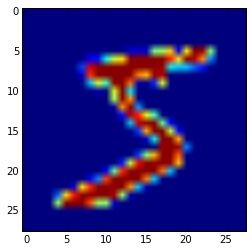

In [80]:
# Load sample of MNIST data.
filename = './MNIST_2000.csv'
X = numpy.loadtxt(filename, dtype='float32')
X, labels = X[:,1:], X[:,0].astype('uint8') # First column is label (0-9)
y = numpy.zeros((X.shape[0], 10), dtype='float32')
for i,label in enumerate(labels):
    y[i, label] = 1.0

# Show example image. 
plt.imshow(X[0,:].reshape(28,28))

# Split data into train, test.
X_train, y_train = X[:1000, :], y[:1000, :]
X_test, y_test = X[1000:, :], y[1000:, :]

# Create pylearn2 dataset objects.
from pylearn2.datasets.dense_design_matrix import DenseDesignMatrix
dataset_train = DenseDesignMatrix(X=X_train, y=y_train)
dataset_test = DenseDesignMatrix(X=X_test, y=y_test)
print dataset_train.X.shape

In [81]:
y[:10,]

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

# Model
Deep neural network models are created in Pylearn2 using the Multi-Layer Perceptron (MLP) class. The network architecture is specified by a list of Layer objects, each of which consists of a linear tranformation followed by a non-linear activation function.

In [120]:
layers = []
nvis = dataset_train.X.shape[1] # Number of input features.
nhid = 100 # Hidden neurons per layer.

# Layer 0
istdev = 1.0/numpy.sqrt(nvis)         # Initial weights selected from normal distribution.
layer = pylearn2.models.mlp.RectifiedLinear(layer_name = 'h0', dim=nhid, istdev=istdev)
layers.append(layer)

# Layer 1
istdev = 1.0/numpy.sqrt(nhid)
layer = pylearn2.models.mlp.RectifiedLinear(layer_name = 'h1', dim=nhid, istdev=istdev)
layers.append(layer)

# Output layer.
layer = mlp.Softmax(layer_name='y', n_classes=10, istdev=0.001)
layers.append(layer)

# MLP Model
model = pylearn2.models.mlp.MLP(layers, nvis=nvis, seed=36)

# Training Algorithm
Neural networks are typically trained using stochastic gradient descent (SGD). There are a number of tricks and parameter choices that go into this. 

In [121]:
# Cost/objective function.
cost = pylearn2.costs.mlp.Default()      # Defaults to cross-entropy loss for softmax output.
    
# Algorithm
args = {}
args['cost'] = cost
args['learning_rate'] = 0.1
args['batch_size']    = 100
args['learning_rule'] = pylearn2.training_algorithms.learning_rule.Momentum(init_momentum = 0.5)
args['monitoring_dataset'] = {'train':dataset_train, 'test':dataset_test}
args['termination_criterion'] = pylearn2.termination_criteria.EpochCounter(max_epochs=20)
algorithm = pylearn2.training_algorithms.sgd.SGD(**args)

# Train object.
filename_model = './model_mnist.pkl'
train = pylearn2.train.Train(dataset=dataset_train,
                             model=model,
                             algorithm=algorithm,
                             #extensions=extensions,
                             save_path=filename_model,
                             save_freq=5)

# Train model

In [122]:
# Run training loop.
train.main_loop()
print 'Model finished training.'

Parameter and initial learning rate summary:
	h0_W: 0.10000000149
	h0_b: 0.10000000149
	h1_W: 0.10000000149
	h1_b: 0.10000000149
	softmax_b: 0.10000000149
	softmax_W: 0.10000000149
Compiling sgd_update...
Compiling sgd_update done. Time elapsed: 1.096066 seconds
compiling begin_record_entry...
compiling begin_record_entry done. Time elapsed: 0.423841 seconds
Monitored channels: 
	learning_rate
	momentum
	test_h0_col_norms_max
	test_h0_col_norms_mean
	test_h0_col_norms_min
	test_h0_max_x_max_u
	test_h0_max_x_mean_u
	test_h0_max_x_min_u
	test_h0_mean_x_max_u
	test_h0_mean_x_mean_u
	test_h0_mean_x_min_u
	test_h0_min_x_max_u
	test_h0_min_x_mean_u
	test_h0_min_x_min_u
	test_h0_range_x_max_u
	test_h0_range_x_mean_u
	test_h0_range_x_min_u
	test_h0_row_norms_max
	test_h0_row_norms_mean
	test_h0_row_norms_min
	test_h1_col_norms_max
	test_h1_col_norms_mean
	test_h1_col_norms_min
	test_h1_max_x_max_u
	test_h1_max_x_mean_u
	test_h1_max_x_min_u
	test_h1_mean_x_max_u
	test_h1_mean_x_mean_u
	test_h1_

In [135]:
# Load saved model.
model = pickle.load(open(filename_model, 'r'))

# Print objective function after training.
channels = model.monitor.channels
print 'Train objective = %f' % channels['train_y_misclass'].val_record[-1]
print 'Valid objective = %f' % channels['test_y_misclass'].val_record[-1]

Train objective = 0.016000
Valid objective = 0.126000


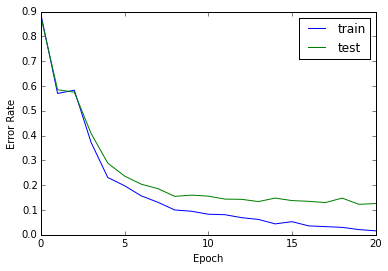

In [137]:
# Plot objective function.
plt.plot(channels['train_y_misclass'].val_record, label='train')
plt.plot(channels['test_y_misclass'].val_record, label='test')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()

# Plot other monitor channels

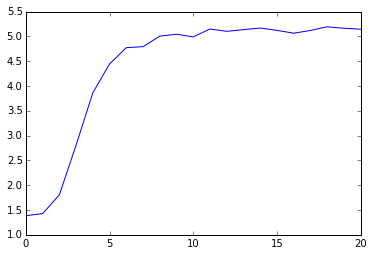

In [141]:
# Plot the maximum neuron activation in hidden layer 0.
# This type of analysis can be useful to debug problems with the learning.  
plt.plot(channels['train_h0_max_x_max_u'].val_record)
plt.ylabel('Max neuron activation.')